# LSTM-RNN

In [1]:
from dotenv import load_dotenv
import sys
import warnings

from __init__ import get_base_path
import data.load_data as load_data
from model_utils import FeatureStore, NonZeroLabelEncoder, grab_bag_train_test_split, pad_collate, SignalClassificationDataset, DynamicLSTM

import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

load_dotenv()
warnings.filterwarnings('ignore')


In [2]:
rnn_data_dir = get_base_path() + os.getenv('RNN_DATA_DIR')

In [3]:
random_seed = os.getenv('RANDOM_SEED')
torch.manual_seed(random_seed)

### Load Data

In [4]:
csv_file = load_data.combined_csv
# csv_file = load_data.combined_sample_csv

if os.path.exists(csv_file):
    pass
else:
    load_data.__main__()
df = pd.read_csv(csv_file,index_col=0)

# datatyping that may not be retained by csv
dp = load_data.DataPreprocessor(df)
df = dp.cast_data_types().get_dataframe() 

### Features

In [5]:
features = FeatureStore(df)

X_features = features.R1_waves
y_features = features.y_tertiary
# X_features = ['R1_Phase_A_power_wave']

X = df.loc[:,X_features + ['sample_id']]
y = df.loc[:,y_features]

### Train Test Split

In [6]:
X_train, y_train, X_test, y_test, train_ids, test_ids = grab_bag_train_test_split(X, y, df['sample_id'], return_ids=True)
for i in X_train, y_train, X_test, y_test, train_ids, test_ids:
    print(len(i))

62847
62847
15441
15441
442
110


### MinMaxScaler

In [7]:
scl = MinMaxScaler()
scl.fit(X_train[X_features])
X_train[X_features], X_test[X_features] = scl.transform(X_train[X_features]), scl.transform(X_test[X_features])

### Encoding

* Label Encode Y Classes
* Because we will use zero padding we use a custom label encoder

In [8]:
enc = LabelEncoder()
# enc = NonZeroLabelEncoder()

enc.fit(y_train)
y_train, y_test = enc.transform(y_train), enc.transform(y_test)

y_class_encodings = [i for (i, c) in tuple(enumerate(enc.classes_))]
y_class_encodings

[0, 1, 2]

### Dataset, DataLoader

1. extract individual signal lengths
2. pack using PyTorch padded sequences which allow variable length sequences to be sent to LSTM, without computation over the padded zeroes

In [9]:
y_class_encodings = [i for (i, c) in tuple(enumerate(enc.classes_))]
k_classes = len(y_class_encodings)
x_train_vectors, x_test_vectors, y_train_vectors, y_test_vectors = [],[],[],[]

for encoding in y_class_encodings:
    # subset train and test dataframes for the class label (ie '0'/'attack')
    train_filt, test_filt = y_train == encoding, y_test == encoding
    X_train_filt, X_test_filt = X_train.loc[train_filt], X_test.loc[test_filt]
    train_samples, test_samples = X_train_filt['sample_id'].unique(), X_test_filt['sample_id'].unique()

    # partition result by sample_id, and accumulate vectors
    for sample in train_samples:
        s = X_train_filt.loc[X_train_filt['sample_id'] == sample,X_features]
        x_train_vectors += [torch.tensor(s.to_numpy(),dtype=torch.float)]
        # y_train_vectors += [torch.tensor(np.full(shape=(len(s),),fill_value=encoding),dtype=torch.float)]
        y_train_vectors += [torch.tensor(np.full((1,),fill_value=encoding),dtype=torch.long)]

    for sample in test_samples:
        s = X_test_filt.loc[X_test_filt['sample_id'] == sample,X_features]
        x_test_vectors += [torch.tensor(s.to_numpy(),dtype=torch.float)]
        # y_test_vectors += [torch.tensor(np.full(shape=(len(s),),fill_value=encoding),dtype=torch.float)]
        y_test_vectors += [torch.tensor(np.full((1,),fill_value=encoding),dtype=torch.long)]


In [10]:
# dataset
train_dataset = SignalClassificationDataset(signals=x_train_vectors,labels=y_train_vectors)
test_dataset = SignalClassificationDataset(signals=x_test_vectors,labels=y_test_vectors)

In [11]:
# dataloader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=pad_collate)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=pad_collate)

### LSTM

In [12]:
# model training hyperparameters
input_size = len(X_features)
output_size = len(y_class_encodings)
hidden_size = 9
num_layers = 3
learning_rate = 0.001

In [13]:
model = DynamicLSTM(input_size = input_size,
                    hidden_size = hidden_size,
                    num_layers = num_layers,
                    output_size = output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Training Loop

In [ ]:
# Train
n_epochs = 50

# Track accuracy and loss
n_samples = 0
n_correct = 0
training_logits = []
training_loss = []
training_accuracy = []

for epoch in range(n_epochs):
    for i, (x, y, x_lens, y_lens) in enumerate(train_dataloader):
        # reset gradients
        optimizer.zero_grad()
        y = y.view(-1)
        
        # forward
        out, __ = model(x, x_lens)
        loss = criterion(out, y)
     
        # back
        loss.backward()
        optimizer.step()

        # track performance

        # losses
        training_logits += [out]
        training_loss += [loss]

        # accuracy
        __, predicted = torch.max(out, 1)
        correct = (predicted == y).sum().detach().numpy()
        n_samples += y.size(0)
        n_correct += correct
        training_accuracy += [n_correct / n_samples]

        if (i+1) % 100 != 0:
            print(f"Epoch: {epoch+1}/{n_epochs}, Step {i+1}, Training Loss {loss.item():.4f}, Accuracy {n_correct/n_samples:.4f}")

PATH = './dynamic_lstm.pth'
torch.save(model.state_dict(), PATH)

Epoch: 1/50, Step 1, Training Loss 0.9630, Accuracy 0.8750
Epoch: 1/50, Step 2, Training Loss 1.0052, Accuracy 0.8438
Epoch: 1/50, Step 3, Training Loss 0.9590, Accuracy 0.8542
Epoch: 1/50, Step 4, Training Loss 1.0384, Accuracy 0.8125
Epoch: 1/50, Step 5, Training Loss 1.0115, Accuracy 0.8000
Epoch: 1/50, Step 6, Training Loss 0.9579, Accuracy 0.8125
Epoch: 1/50, Step 7, Training Loss 1.0183, Accuracy 0.7946
Epoch: 1/50, Step 8, Training Loss 0.9994, Accuracy 0.7969
Epoch: 1/50, Step 9, Training Loss 0.9728, Accuracy 0.8056
Epoch: 1/50, Step 10, Training Loss 1.0336, Accuracy 0.7937
Epoch: 1/50, Step 11, Training Loss 0.9710, Accuracy 0.8011
Epoch: 1/50, Step 12, Training Loss 0.9971, Accuracy 0.8021
Epoch: 1/50, Step 13, Training Loss 0.9952, Accuracy 0.8029
Epoch: 1/50, Step 14, Training Loss 0.9125, Accuracy 0.8170
Epoch: 1/50, Step 15, Training Loss 1.0423, Accuracy 0.8042
Epoch: 1/50, Step 16, Training Loss 1.0201, Accuracy 0.8008
Epoch: 1/50, Step 17, Training Loss 1.0469, Accur

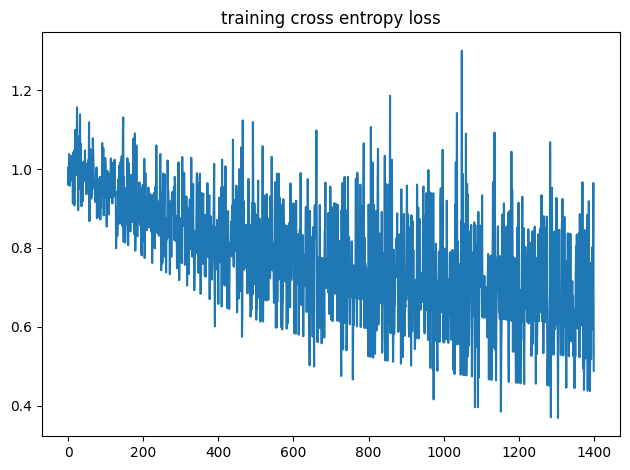

In [ ]:
training_loss = [loss.detach().numpy() for loss in training_loss]
plt.plot(training_loss)
plt.title('training cross entropy loss')
plt.tight_layout()

Text(0.5, 1.0, 'training accuracy')

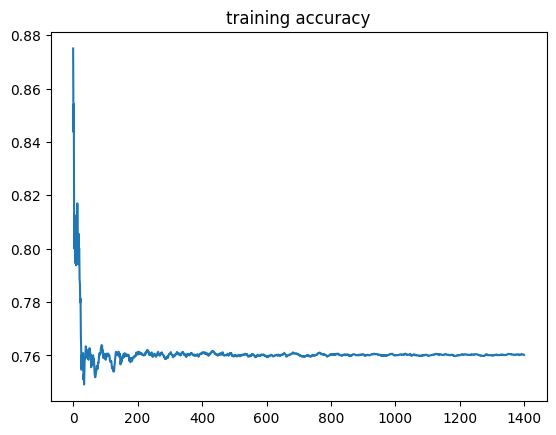

In [16]:
plt.plot(training_accuracy)
plt.title('training accuracy')

In [17]:
model.eval()

DynamicLSTM(
  (lstm): LSTM(18, 9, num_layers=3, batch_first=True)
  (fc): Linear(in_features=9, out_features=3, bias=True)
)

In [18]:
# model = DynamicLSTM()
# model.load_state_dict(torch.load(PATH, weights_only=True))

In [19]:
# Test - we don't compute gradients
with torch.no_grad():

    n_samples = 0
    n_correct = 0
    test_logits = []
    test_loss = []
    test_pred = []
    test_accuracy = []

    for i, (x, y, x_lens, y_lens) in enumerate(test_dataloader):
        y = y.view(-1)

        out, __ = model(x, x_lens)
        loss = criterion(out, y)
        test_logits == [out]
        test_loss += [loss]
    
        # predict
        __, predicted = torch.max(out, 1)
        test_pred += [predicted]
    
        # track accuracy
        correct = (predicted == y).sum().detach().numpy()
        n_samples += y.size(0)
        n_correct += correct
        test_accuracy += [n_correct / n_samples]
         
        # evaluate periodically
        if (i+1) % 100 != 0:
            print(f"Epoch: {epoch+1}/{n_epochs}, Step {i+1}, Training Loss {loss.item():.4f}, Accuracy {n_correct/n_samples:.4f}")

Epoch: 50/50, Step 1, Training Loss 0.5956, Accuracy 0.8125
Epoch: 50/50, Step 2, Training Loss 0.7611, Accuracy 0.7500
Epoch: 50/50, Step 3, Training Loss 0.5980, Accuracy 0.7708
Epoch: 50/50, Step 4, Training Loss 0.5980, Accuracy 0.7812
Epoch: 50/50, Step 5, Training Loss 0.8828, Accuracy 0.7500
Epoch: 50/50, Step 6, Training Loss 0.8427, Accuracy 0.7292
Epoch: 50/50, Step 7, Training Loss 0.6312, Accuracy 0.7364


# Evaluation